 Concepto de encoder–decoder con RNNs
- Encoder:
- Recibe el texto de entrada palabra por palabra (token por token).
- Actualiza su estado oculto en cada paso, acumulando información del contexto.
- Al final, produce un estado oculto final que intenta condensar el significado completo de la oración.
- Decoder:
- Toma ese estado oculto final como punto de partida.
- Genera la traducción palabra por palabra.
- En cada paso, actualiza su propio estado oculto para mantener el contexto de lo que ya ha generado.

👉 Puedes pensar en el estado oculto final del encoder como un vector de embedding que resume la oración completa.

📉 Limitación principal
El gran problema de este enfoque es que:
- El decoder no puede acceder directamente a los estados ocultos anteriores del encoder.
- Depende únicamente del último estado oculto del encoder.
- Esto provoca pérdida de contexto en oraciones largas o complejas, donde las dependencias entre palabras pueden estar muy alejadas.

🌟 Por qué es importante
Esta limitación fue una de las razones por las que se desarrollaron mecanismos de atención y, más adelante, los transformers. La atención permite que el decoder consulte directamente todos los estados del encoder, no solo el último, resolviendo el problema de pérdida de contexto.
En otras palabras: los RNN encoder-decoder fueron un paso fundamental, pero tenían un cuello de botella en el estado oculto final, lo que motivó la evolución hacia arquitecturas más poderosas como la atención y los transformers.


## 3.2 Capturing data dependencies with attetion mechanisms
Aunque las RNN funcionan bien para traducir oraciones cortas, no funcionan tan bien para textos más largos ya que no tienen acceso directo a las palabras anteriores en la entrada. Una gran limitación de este enfoque es que la RNN debe recordar toda la entrada codificada en un único estado oculto antes de pasarlo al decodificador.

Mecanismo de atencion de Badanau RNN inspiro para el desarollo del mecnaismo de attencion para la arquitectura de los transformers.

La autoatención es un mecanismo que permite que cada posición en la secuencia de entrada considere la relevancia de, o “preste atención a”, todas las demás posiciones en la misma secuencia al calcular la representación de una secuencia. La autoatención es un componente clave de los LLM contemporáneos basados en la arquitectura transformer, como la serie GPT.

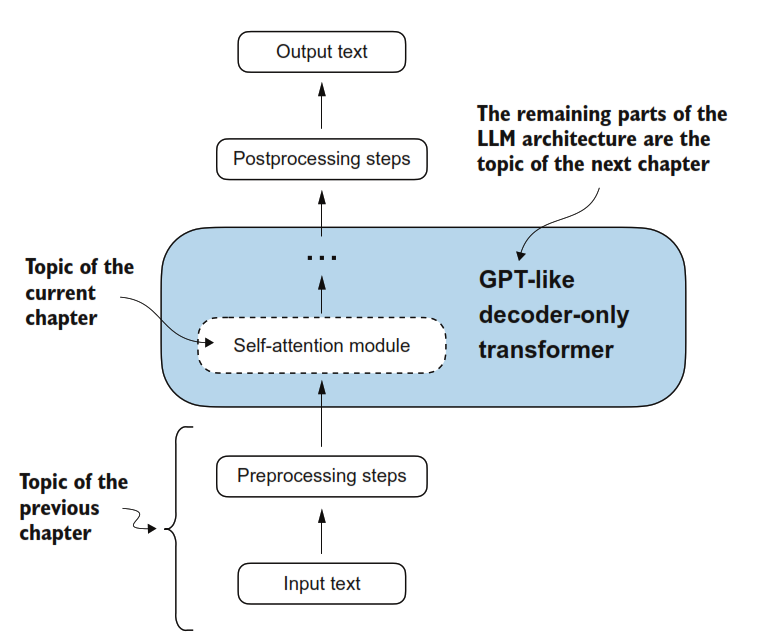

In [2]:
import torch

### 3.3.1 Mecanismo de autoatencion sin pesos entrenables

In [3]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [4]:
query = inputs[1]         #El segundo token de entrada actúa como la consulta (query).
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attn_scores_2[i]=torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [5]:
# Un metodo de normalizacion la sumatoria de la
# normalizacion debe ser 1
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print('Pesos de Atencion: ', attn_weights_2_tmp)
print('Sum: ', attn_weights_2_tmp.sum())

Pesos de Atencion:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)


In [6]:
# Softmax : es mejor para manejar valores extremos y
#ofrece propiedades de gradiente más favorables durante el entrenamiento

def softmax_naive(x):
  return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print('Pesos de Atencion: ', attn_weights_2_naive)
print('Sum: ', attn_weights_2_naive.sum())


Pesos de Atencion:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


In [7]:
#(softmax_naive) puede enfrentar problemas de inestabilidad numérica,
#como desbordamiento (overflow) o subdesbordamiento (underflow)
# al trabajar con valores de entrada muy grandes o muy pequeños.
# por eso se recomienda utilizar la implementación de PyTorch, que ha sido
# optimizada para rendimiento y estabilidad:

attn_weights_2 = torch.softmax(attn_scores_2, dim =0)
print('Pesos de Atención: ', attn_weights_2)
print('Sum: ', attn_weights_2.sum())

Pesos de Atención:  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:  tensor(1.)


In [8]:
# calcular el vector de contexto
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
  context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 3.3.2 Computing attention weights for all input tokens

#### Paso 1. Calcula los puntajes de atención como productos punto entre las entradas.

In [9]:
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
  for j, x_j in enumerate(inputs):
    attn_scores[i,j]=torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [10]:
# Mismos resultado usando multiplicacion de matriz
# los for loops en python son lentos
attn_scores= inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


### Paso 2. Normalizamos cada fila para que los valores en cada una sumen 1:


In [11]:
# dim= -1 1indicando que la función softmax debe aplicar la normalización a lo largo de
# la última dimensión del tensor attn_scores

attn_weigths = torch.softmax(attn_scores, dim=-1)
print(attn_weigths)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [12]:
# verificando que todas las filas sumen 1
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Fila 2 sum: ", row_2_sum)
print("Todas las filas sum: ", attn_weigths.sum(dim=-1))

Fila 2 sum:  1.0
Todas las filas sum:  tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


### Paso 3. usamos multiplicación de matrices para calcular todos los vectores de contexto de manera eficiente


In [13]:
all_context_vecs = attn_weigths @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [14]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


## 3.4 Implementando autoatención con pesos entrenables.

Este mecanismo de autoatención también se llama atención por producto punto escalado. La figura muestra cómo este mecanismo de autoatención encaja en el contexto más amplio de la implementación de un LLM.

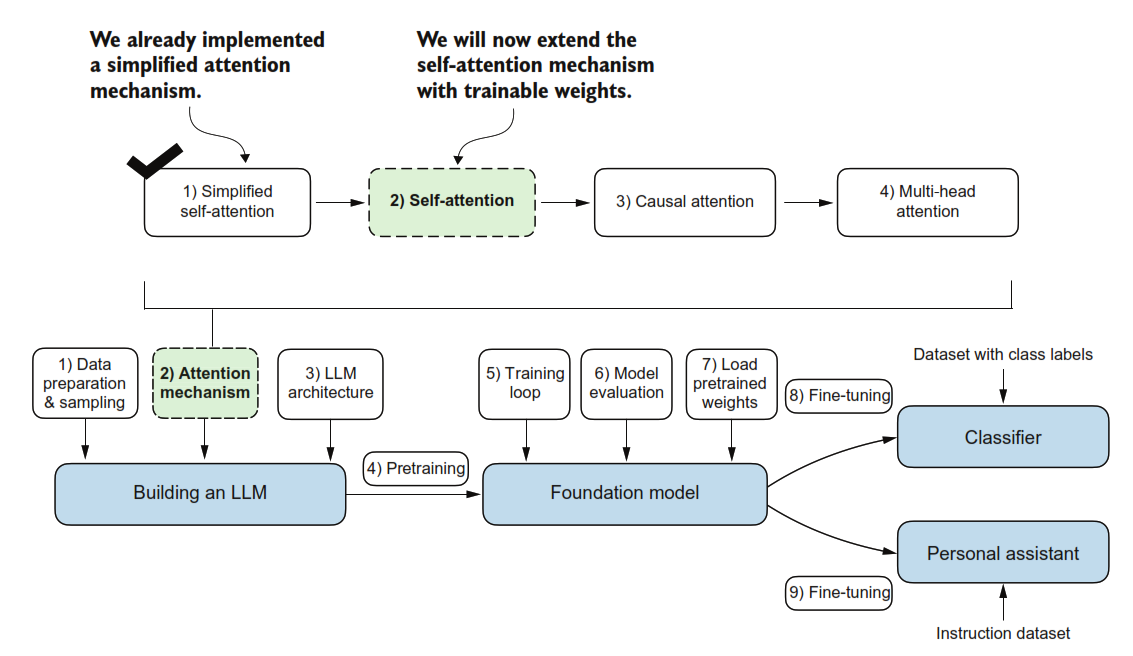

### 3.4.1 Cálculo de los pesos de atención paso a paso
Implementaremos el mecanismo de autoatención paso a paso introduciendo las tres matrices de pesos entrenables W_q, W_k y W_v. Estas tres matrices se usan para proyectar los tokens de entrada embebidos, x^{(i)}, en vectores de consulta (query), clave (key) y valor (value), respectivamente

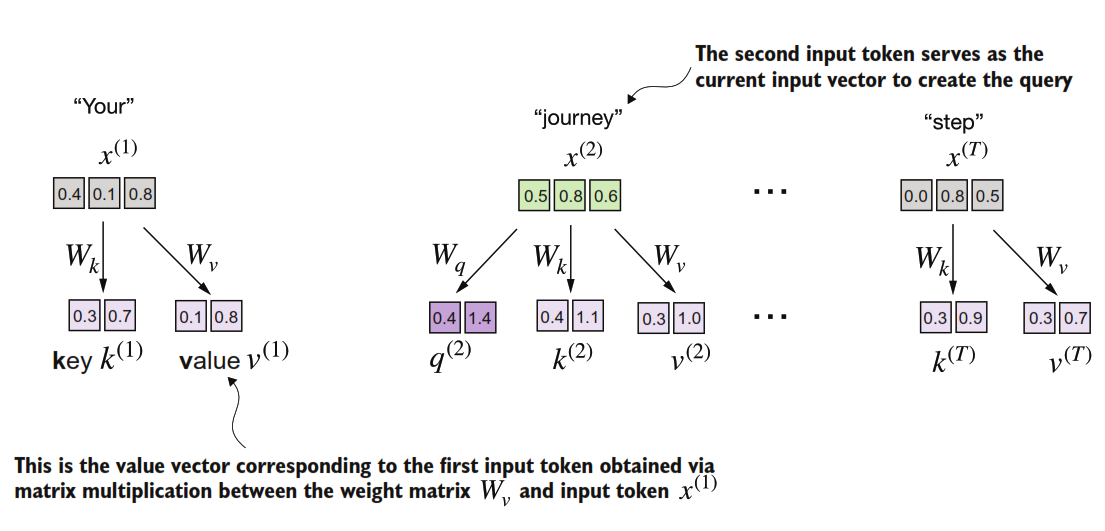

In [15]:
# Comenzamos aquí calculando solo un vector de contexto,
# z^{(2)}, con fines ilustrativos.

x_2 = inputs[1]                 # Segundo elemento de entrada
d_in = inputs.shape[1]          # Tamaño de entrada del Embedding, d= 3
d_out = 2                       # Tamaño del embedding de salida

In [20]:
# Inicializamos las tres matrices de pesos Wq, Wk y Wv
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
# Establecemos requires_grad=False para reducir el desorden en las salidas,
# es decir, para evitar que PyTorch rastree los gradientes de esas matrices
# durante operaciones que no requieren entrenamiento.


In [17]:
# calculamos los vectores de consulta (query), clave (key) y valor (value).
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


In [26]:
# obteniendo las keys y los valores via multiplicacion de matrix
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape: ", keys.shape)
print("values.shape: ", values.shape)


keys.shape:  torch.Size([6, 2])
values.shape:  torch.Size([6, 2])


In [27]:
# calcular los valores de atención w22
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [30]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [31]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [32]:
attn_weights_2.sum()

tensor(1.)


Parámetros de pesos vs. pesos de atención
En las matrices de pesos W, el término “peso” es una abreviación de “parámetros de pesos”, es decir, los valores de una red neuronal que se optimizan durante el entrenamiento. Esto no debe confundirse con los pesos de atención.
Como ya vimos, los pesos de atención determinan en qué medida un vector de contexto depende de las diferentes partes de la entrada (es decir, hasta qué punto la red se enfoca en distintas partes de la entrada).
En resumen:
- Parámetros de pesos → son los coeficientes fundamentales, aprendidos, que definen las conexiones de la red.
- Pesos de atención → son valores dinámicos y específicos del contexto, calculados en cada paso para decidir qué partes de la entrada son más relevantes.



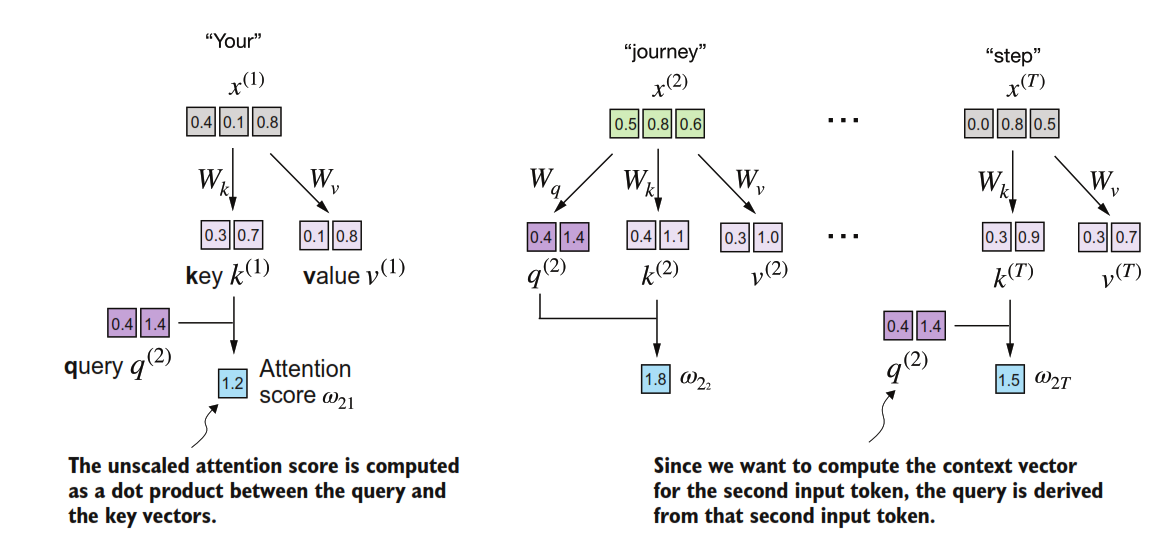

### Justificación del mecanismo de atención por producto punto escalado
La razón por la cual se normalizan las puntuaciones de atención dividiéndolas por la dimensión de incrustación (embedding) es mejorar el rendimiento del entrenamiento evitando gradientes pequeños. Por ejemplo, al aumentar la dimensión de incrustación —que en modelos tipo GPT suele superar los 1.000— los productos punto pueden volverse muy grandes. Esto provoca que, al aplicar la función softmax, los gradientes durante la retropropagación se vuelvan muy pequeños.
A medida que los productos punto aumentan, la función softmax se comporta más como una función escalón, lo que lleva a gradientes cercanos a cero. Estos gradientes tan pequeños pueden ralentizar drásticamente el aprendizaje o incluso hacer que el entrenamiento se estanque.
Por eso se divide por la raíz cuadrada de la dimensión de incrustación: este ajuste es lo que da nombre al mecanismo de atención como atención por producto punto escalado (scaled-dot product attention).


In [33]:
#  suma ponderada de los vectores de valor. En este caso, los pesos de atención
# actúan como factores de ponderación que determinan la
# importancia relativa de cada vector de valor.

context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### ¿Por qué se usan los términos query, key y value?
Los términos “clave” (key), “consulta” (query) y “valor” (value) en el contexto de los mecanismos de atención provienen del ámbito de la recuperación de información y las bases de datos, donde se utilizan conceptos similares para almacenar, buscar y recuperar información.

Una consulta (query) es análoga a una búsqueda en una base de datos. Representa el elemento actual (por ejemplo, una palabra o token en una oración) en el que el modelo se enfoca o intenta comprender. La consulta se utiliza para explorar las demás partes de la secuencia de entrada y determinar cuánta atención se debe prestar a cada una.
La clave (key) es como una clave de base de datos usada para indexar y buscar. En el mecanismo de atención, cada elemento de la secuencia de entrada (por ejemplo, cada palabra en una oración) tiene una clave asociada. Estas claves se utilizan para comparar con la consulta.
El valor (value) en este contexto es similar al valor en un par clave-valor de una base de datos. Representa el contenido real o la representación de los elementos de entrada. Una vez que el modelo determina qué claves (y por lo tanto qué partes de la entrada) son más relevantes para la consulta (el elemento en foco), recupera los valores correspondientes.

### 3.4.2 Implmentando una clase en Python de  mecanismos de auto-atencion

In [36]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.W_query = nn.Parameter(torch.rand(d_in, d_out))
    self.W_key = nn.Parameter(torch.rand(d_in, d_out))
    self.W_value = nn.Parameter(torch.rand(d_in, d_out))

  def forward(self, x):
    keys = x @ self.W_key
    queries = x @ self.W_query
    values = x @ self.W_value
    attn_scores = queries @ keys.T # Omega
    attn_weigths = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    context_vec = attn_weigths @ values
    return context_vec

In [37]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


nn.Linear cuenta con un esquema optimizado de inicialización de pesos, lo que contribuye a un entrenamiento del modelo más estable y efectivo


In [41]:
# A self-attention class using PyTorch’s Linea

class SelfAttention_v2(nn.Module):
  def __init__(self, d_in, d_out, qkv_bias=False):
    super().__init__()
    self.W_query= nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key= nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value= nn.Linear(d_in, d_out, bias=qkv_bias)

  def forward(self, x):
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)
    attn_scores = queries @ keys.T
    attn_weigths = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    context_vec = attn_weigths @ values
    return context_vec

In [42]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


Ejercicio 3.1:
* Comparando SelfAttention_v1 y SelfAttention_v2
Ten en cuenta que nn.Linear en SelfAttention_v2 utiliza un esquema de inicialización de pesos diferente al de nn.Parameter(torch.rand(d_in, d_out)) usado en SelfAttention_v1, lo que provoca que ambos mecanismos produzcan resultados distintos. Para verificar que ambas implementaciones —SelfAttention_v1 y SelfAttention_v2— son similares en lo demás, podemos transferir las matrices de peso de un objeto SelfAttention_v2 a uno de SelfAttention_v1, de modo que ambos objetos produzcan los mismos resultados.
Tu tarea consiste en asignar correctamente los pesos de una instancia de SelfAttention_v2 a una instancia de SelfAttention_v1. Para hacerlo, necesitas comprender la relación entre los pesos en ambas versiones.
(Pista: nn.Linear almacena la matriz de pesos en forma transpuesta).
Después de realizar la asignación, deberías observar que ambas instancias generan las mismas salidas.


In [43]:
torch.manual_seed(123)  # Semilla de la SelfAttention_v1
sa_v1 = SelfAttention_v1(d_in,d_out)

torch.manual_seed(123)  # Semilla SelfAttention_v2 misma semilla para que pesos iniciales sean comparables
sa_v2 = SelfAttention_v2(d_in,d_out)


nn.Linear almacena la matriz de pesos (weight) de forma transpuesta en comparación con cómo la definimos en SelfAttention_v1. Por lo tanto, al transferir los pesos, debemos transponer las matrices de pesos de sa_v2 antes de asignarlas a sa_v1. Los sesgos (bias), si existieran (qkv_bias=True), se transfieren directamente sin transponer.

In [44]:
sa_v1.W_query.data = sa_v2.W_query.weight.T
sa_v1.W_key.data = sa_v2.W_key.weight.T
sa_v1.W_value.data = sa_v2.W_value.weight.T

In [45]:
# Comparaciónde resultados
output_v1 = sa_v1(inputs)
output_v2 = sa_v2(inputs)

print("Salida de SelfAttention_v1:")
print(output_v1)

print("\nSalida de SelfAttention_v2:")
print(output_v2)

Salida de SelfAttention_v1:
tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)

Salida de SelfAttention_v2:
tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


### 3.5 Ocultando palabras futuras con atención causal

En la atención causal, los pesos de atención por encima de la diagonal son enmascarados, lo que garantiza que, para cualquier entrada dada, el modelo de lenguaje (LLM) no pueda utilizar tokens futuros al calcular los vectores de contexto mediante los pesos de atención.

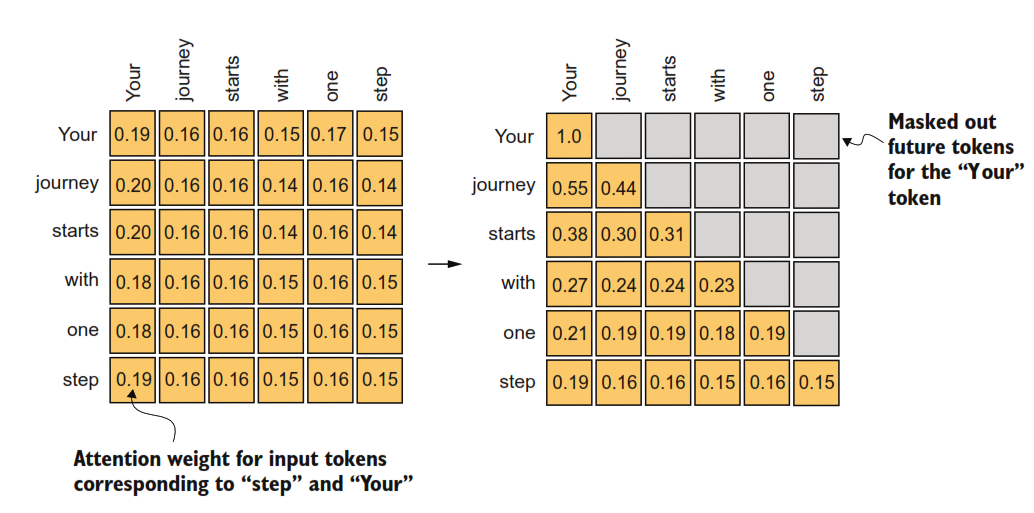

In [52]:
# implementar la máscara de atención causal
# puntciones e atencion (attenion scores)

queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


In [53]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)
# mask with 0' s above diagonal

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [54]:
masked_simple = attn_weights*mask_simple
print(masked_simple)
# multiplica las puntacionesde de atencion y con  la mask

tensor([[0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1749, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1637, 0.1749, 0.1746, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.0000, 0.0000],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<MulBackward0>)


In [55]:
#Volver a normalizar los pesos de atención para que la suma en
#cada fila sea igual a 1.

row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm=masked_simple/row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<DivBackward0>)


Fugas de información

Cuando aplicamos una máscara y luego renormalizamos los pesos de atención, podría parecer que la información de los tokens futuros (que pretendemos enmascarar) aún podría influir en el token actual, ya que sus valores forman parte del cálculo de la softmax.
Sin embargo, el punto clave es que al renormalizar los pesos de atención después del enmascaramiento, lo que realmente estamos haciendo es recalcular la softmax sobre un subconjunto más pequeño, ya que las posiciones enmascaradas no contribuyen al valor de la softmax.
La elegancia matemática de la función softmax radica en que, aunque inicialmente incluye todas las posiciones en el denominador, después del enmascaramiento y la renormalización, el efecto de las posiciones enmascaradas se anula: no aportan nada significativo al resultado de la softmax.
En términos más simples, después de aplicar la máscara y renormalizar, la distribución de los pesos de atención es como si se hubiera calculado solo entre las posiciones no enmascaradas desde el principio.
Esto garantiza que no haya fuga de información desde los tokens futuros (o cualquier otro token enmascarado), tal como se pretende.


In [56]:
# enmascaraminetso con -inf
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


In [57]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


### 3.5.2 Enmascarar pesos de atención adicionales con dropout
Dropout en aprendizaje profundo es una técnica en la que se ignoran aleatoriamente ciertas unidades de la capa oculta durante el entrenamiento, lo que equivale a “eliminarlas”. Este método ayuda a prevenir el sobreajuste al asegurar que el modelo no dependa excesivamente de ningún conjunto específico de unidades ocultas.


In [58]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [59]:
# Dropout a la matriz de pesos de atención
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6380, 0.6816, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5090, 0.5085, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4120, 0.0000, 0.3869, 0.0000, 0.0000],
        [0.0000, 0.3418, 0.3413, 0.3308, 0.3249, 0.0000]],
       grad_fn=<MulBackward0>)


In [60]:
batch = torch.stack((inputs,inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


### 3.5.3 Implemenatando  la class causal attention

In [61]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)               # Conpared to the previous SelfAttention_v1, add dropout layer
        self.register_buffer(
           'mask',
           torch.triu(torch.ones(context_length, context_length),
           diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape       # Se cambió la transposición
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        # `:num_tokens` para tener en cuenta los casos en que el número de tokens
        # en el lote es menor que el tamaño de contexto soportado

        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec


In [62]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs =  ca(batch)
print('context_vecs.shape: ', context_vecs.shape)

context_vecs.shape:  torch.Size([2, 6, 2])


### 3.6 Extender la atención de una sola cabeza a atención de múltiples cabezas
El término “multi-cabeza” se refiere a dividir el mecanismo de atención en múltiples “cabezas”, cada una funcionando de manera independiente. En este contexto, un único módulo de atención causal puede considerarse como atención de una sola cabeza, donde solo hay un conjunto de pesos de atención procesando la entrada de forma secuencial.


### 3.6.1 Apilar múltiples capas de atención de una sola cabeza
Implementar atención de múltiples cabezas implica crear múltiples instancias del mecanismo de autoatención.

In [63]:
# Una clase contenedora para implementar atención de múltiples cabezas
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(
                 d_in, d_out, context_length, dropout, qkv_bias
             )
             for _ in range(num_heads)]
        )
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [64]:
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3 , 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0,num_heads=2
)
context_vecs = mha(batch)
print(context_vecs)

print('context_vecs.shape: ', context_vecs.shape)


tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape:  torch.Size([2, 6, 4])


### Ejercico 3.2
Devolver vectores de embedding bidimensionales, debes ajustar los argumentos de entrada en la llamada a MultiHeadAttentionWrapper(..., num_heads=2) para que el vector de contexto resultante tenga dos dimensiones, en lugar de cuatro, sin cambiar la implementación de la clase.


In [65]:
d_out = 1
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)

print('context_vecs.shape: ', context_vecs.shape)

tensor([[[0.0189, 0.2729],
         [0.2181, 0.3037],
         [0.2804, 0.3125],
         [0.2830, 0.2793],
         [0.2476, 0.2541],
         [0.2748, 0.2513]],

        [[0.0189, 0.2729],
         [0.2181, 0.3037],
         [0.2804, 0.3125],
         [0.2830, 0.2793],
         [0.2476, 0.2541],
         [0.2748, 0.2513]]], grad_fn=<CatBackward0>)
context_vecs.shape:  torch.Size([2, 6, 2])


### 3.6.2 Implementar atención de múltiples cabezas con división de pesos
En lugar de mantener dos clases separadas, MultiHeadAttentionWrapper y CausalAttention, podemos combinar estos conceptos en una sola clase llamada MultiHeadAttention. Además de fusionar el código de MultiHeadAttentionWrapper con el de CausalAttention, realizaremos algunas otras modificaciones para implementar la atención de múltiples cabezas de manera más eficiente


In [66]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out debe ser divisible por num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce la dimensión de proyección para que coincida con la dimensión de salida deseada

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Capa lineal para combinar las salidas de las cabezas
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # Como en `CausalAttention`, si el número de tokens excede `context_length`,
        # esto provocará errores en la creación de la máscara más abajo.
        # En la práctica, esto no es un problema ya que el LLM (capítulos 4–7) asegura que las entradas
        # no excedan `context_length` antes de llegar a este método forward.

        keys = self.W_key(x)  # Forma: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Dividimos implícitamente la matriz agregando una dimensión `num_heads`
        # Desenrollamos la última dimensión: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transposición: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calculamos la atención de producto punto escalado (también conocida como autoatención) con una máscara causal
        attn_scores = queries @ keys.transpose(2, 3)  # Producto punto para cada cabeza

        # Máscara original truncada al número de tokens y convertida a booleano
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Usamos la máscara para rellenar los puntajes de atención
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Forma: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combinamos las cabezas, donde self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # proyección opcional

        return context_vec

# Fijamos la semilla para reproducibilidad
torch.manual_seed(123)

# Extraemos las dimensiones del lote
batch_size, context_length, d_in = batch.shape
d_out = 2

# Creamos la instancia de atención multi-cabeza
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

# Ejecutamos el modelo sobre el lote
context_vecs = mha(batch)

# Mostramos los vectores de contexto y su forma
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


### Ejercicio 3.3: Inicialización de módulos de atención del tamaño de GPT-2
Usando la clase MultiHeadAttention, inicializa un módulo de atención de múltiples cabezas que tenga el mismo número de cabezas de atención que el modelo GPT-2 más pequeño (12 cabezas de atención). Además, asegúrate de usar los tamaños de embedding de entrada y salida correspondientes al modelo GPT-2 (768 dimensiones). Ten en cuenta que el modelo GPT-2 más pequeño admite una longitud de contexto de 1.024 tokens.


In [67]:
# Parámetros similares al GPT-2 pequeño
d_in = 768           # Tamaño de embedding de entrada
d_out = 768          # Tamaño de embedding de salida
context_length = 1024
num_heads = 12
dropout = 0.0        # Sin dropout para este ejemplo

# Inicializar el módulo de atención multi-cabeza
mha = MultiHeadAttention(d_in, d_out, context_length, dropout, num_heads)

# Simular un lote de entrada (por ejemplo, batch de 2 secuencias de 1024 tokens)
batch = torch.randn(2, context_length, d_in)

# Ejecutar el módulo
context_vecs = mha(batch)

# Mostrar resultados
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[ 2.5606e-01, -5.9930e-02,  3.9847e-01,  ...,  2.4789e-01,
           1.8914e-01, -1.3538e-01],
         [ 2.7349e-01,  2.0641e-01,  1.9273e-01,  ...,  2.1027e-01,
           1.5678e-01, -4.5343e-01],
         [ 3.3144e-02,  1.0040e-01,  7.7156e-02,  ..., -3.8450e-02,
          -1.1032e-01, -4.1691e-01],
         ...,
         [-2.5707e-02, -6.9448e-03,  1.0252e-02,  ...,  3.4811e-02,
          -1.6675e-03, -3.0555e-02],
         [-3.2742e-02, -4.4450e-03, -7.9055e-04,  ...,  3.0958e-02,
          -8.3340e-03, -3.2058e-02],
         [-3.0148e-02, -1.3552e-03, -3.0732e-04,  ...,  2.4457e-02,
          -1.4528e-02, -3.3910e-02]],

        [[ 3.2940e-01, -1.7189e-01, -4.2380e-01,  ...,  1.5147e-01,
          -3.5167e-01, -4.5434e-01],
         [-5.7646e-02,  8.6548e-02, -3.5733e-01,  ..., -1.3894e-01,
          -2.9612e-01, -1.3889e-01],
         [ 1.7297e-01,  8.9216e-02,  3.5174e-02,  ..., -1.9757e-01,
          -3.0677e-01, -1.6127e-01],
         ...,
         [-2.5912e-02, -2